# Online DA: 
## CESM LME prior/LIM, HadCRUT5 observations

In [180]:
import sys
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pickle 

In [181]:
import Online_DA_utils as oda

In [207]:
import importlib
importlib.reload(oda)

<module 'Online_DA_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/Online_DA_monthly/recon_scripts/Online_DA_utils.py'>

In [4]:
t=0

### Load L: 

In [5]:
LIM = oda.load_L('cesm_lme_Amon')
LIMd = LIM['LIMd']
LIMd.keys()

Loading: /home/disk/kalman2/mkb22/SI_LIMs/sensitivity_testing/master/LIMcast_cesm_lme_Amon_ntrain_850_1650_cesm_lme_Amon_validy_1651_1850_tas50L0.1_psl50L0.1_zg50L0.1_tos50L0.1_sit50L40_sic50L40_20211202_sqrtWt.pkl


dict_keys(['vec', 'veci', 'val', 'lam_L', 'C_0', 'C_1', 'Gt', 'lam_L_adj', 'npos_eigenvalues', 'E3', 'W_all', 'standard_factor', 'E3_all', 'E_sic', 'var_dict', 'P_train', 'exp_setup', 'frac_neg_eigenvals'])

In [6]:
# Xb_initial = LIM['forecast']['P_train_valid'][:,2399]
# Xb_initial.shape

# Pb_initial = oda.covariance(Xb_initial[:,np.newaxis],Xb_initial[:,np.newaxis].T)
# Pb_initial.shape

In [7]:
Projector_tas = LIMd['E3']['tas']

### Load HadCRUT5 observations: 

In [13]:
HadCRUT_tas, HadCRUT_lat, HadCRUT_lon, HadCRUT_time = oda.load_HadCRUT5()
HadCRUT_lon[:36] = HadCRUT_lon[:36] +360

In [14]:
HadCRUT_tas_nh = HadCRUT_tas[:,18:,:]
HadCRUT_lat_nh = HadCRUT_lat[18:]

In [15]:
nobs_had = np.isfinite(HadCRUT_tas_nh[0,:,:]).sum()
nobs_had

271

In [16]:
HadCRUT_lat_2d = HadCRUT_lat_nh[:,np.newaxis]*np.ones((HadCRUT_lat_nh.shape[0],HadCRUT_lon.shape[0]))
HadCRUT_lon_2d = np.ones((HadCRUT_lat_nh.shape[0],HadCRUT_lon.shape[0]))*HadCRUT_lon[np.newaxis,:]

In [17]:
HadCRUT_obs_1d = HadCRUT_tas_nh[t,np.isfinite(HadCRUT_tas_nh[t,:,:])]
HadCRUT_obs_lat = HadCRUT_lat_2d[np.isfinite(HadCRUT_tas_nh[t,:,:])]
HadCRUT_obs_lon = HadCRUT_lon_2d[np.isfinite(HadCRUT_tas_nh[t,:,:])]

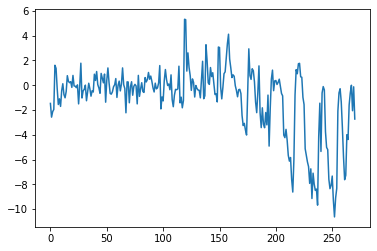

In [171]:
plt.plot(HadCRUT_obs_1d)

### Build R: 

In [18]:
HadCRUT_unc_tas, HadCRUT_unc_lat, HadCRUT_unc_lon, HadCRUT_unc_time = oda.load_HadCRUT5_uncertainty()
HadCRUT_unc_tas_nh = HadCRUT_unc_tas[:,18:,:]
HadCRUT_unc_lat_nh = HadCRUT_unc_lat[18:]

HadCRUT_obs_unc_1d = HadCRUT_unc_tas_nh[t,np.isfinite(HadCRUT_unc_tas_nh[t,:,:])]

In [19]:
R_had = oda.covariance_nans(HadCRUT_obs_unc_1d[:,np.newaxis],HadCRUT_obs_unc_1d[:,np.newaxis].T,anomalize=False)

In [20]:
R_had.min(), R_had.max()

(6.598562306910381e-05, 0.018895988442822746)

## Load initial conditions in lat/lon space: 

In [68]:
priorpath = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
#priorname = 'Prior_state_tas_tos_psl_zg500_sit_sic_latcut0_1_CESM_LME_Amon_time_1650.pkl.npz'
priorname = 'Prior_state_tas_tos_psl_zg500_latcut0_1_sit_sic_latcut40_CESM_LME_Amon_time_1650.pkl.npz'

#priorcov_name = 'Prior_covariance_tas_tos_psl_zg500_sit_sic_latcut0_1_CESM_LME_Amon_time_1650_1850.pkl.npz'
priorcov_name = 'Prior_covariance_tas_tos_psl_zg500_latcut0_1_sit_sic_latcut40_CESM_LME_Amon_time_1650_1850.pkl.npz'

Xb_allvars = np.load(priorpath+priorname)
Xb_allvars_initial = Xb_allvars['Xb_allvars'][:,-12]
Xb_initial = Xb_allvars_initial

Pb_data = np.load(priorpath+priorcov_name)
Pb_initial = Pb_data['Pb_initial']/10

In [158]:
#Pb_initial_stand = np.matmul(Xb_initial_stand[:,np.newaxis],Xb_initial_stand[:,np.newaxis].T)/(Xb_initial_stand.shape[0]-1)

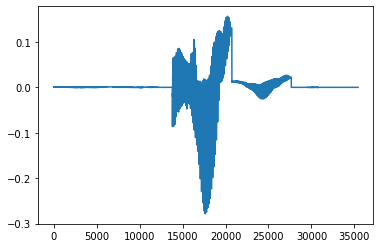

In [183]:
plt.plot(Pb_initial[0,:])

In [ ]:
# Pb_allvars = oda.covariance_nans(Xb_allvars_initial[:,np.newaxis],
#                                  Xb_allvars_initial[:,np.newaxis].T, anomalize=False)

# cesm_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
# save_filename = 'Prior_covariance_tas_tos_psl_zg500_latcut0_1_sit_sic_latcut40_CESM_LME_Amon_time_1850_01.pkl.npz'

# np.savez(cesm_dir+save_filename,Pb_initial=Pb_allvars)

### Build H: 
H should be a matrix of size (nobs, nlalo) filled with zeros and ones. One one per column at the ob location. 

In [161]:
obsmask_filename = 'Hadcrut_data_mask_CESMLME_grid.pkl'
obsmask_loc_filename = 'Hadcrut_data_mask_with_locations_CESMLME_grid.pkl'
obsmask_loc_filename_nh = 'Hadcrut_data_mask_with_locations_CESMLME_grid_NH.pkl'
obscesm_filename_nh = 'Hadcrut_data_on_CESMLME_grid_NH.pkl'

had_ds = pickle.load(open(obsmask_loc_filename_nh,"rb"))
had_mask_nh = had_ds['hadcrut_closest_CESM_gridpoint']
locations = had_ds['lat_lon_locations']

In [162]:
# had_cesm_ds = pickle.load(open(obscesm_filename_nh,"rb"))
# had_on_refgrid = had_mask['had_on_refgrid']
# had_on_refgrid_2d = np.reshape(had_on_refgrid,(had_on_refgrid.shape[0],ndof))

In [163]:
H_cap, nobs, ndof = oda.build_H_time(had_mask_nh[0,:,:])

In [164]:
H = np.zeros((nobs,Xb_initial.shape[0]))
H[:,0:6912] = H_cap

In [ ]:
#H_tas = np.matmul(H_cap, Projector_tas)

# H = np.zeros((nobs,Xb_initial.shape[0]))
# H[:,0:50] = H_tas

## Initial timestep - Kalman Filtering: 

In [188]:
Xb_initial = np.nan_to_num(Xb_initial)
Y = HadCRUT_obs_1d

Xa, K, K_den, diff = oda.solver_KF_update(Xb_initial, Pb_initial, Y, R_had, H)

In [189]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H,Xa))**2)
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

Prior MSE     = 12.351073919279907
Posterior MSE = 0.08156688174871572


In [190]:
diffcov = np.dot(diff[:,np.newaxis],diff[:,np.newaxis].T)/diff.shape[0]
ratio2 = np.diagonal(diffcov)/np.diagonal(K_den)
ratio = np.median(diffcov/K_den)
print('Median Ratio = '+str(np.median(ratio2)))

Median Ratio = 0.9532205423630303


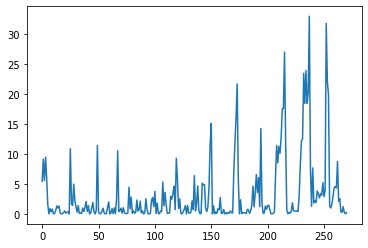

In [191]:
plt.plot(np.diagonal(diffcov)/np.diagonal(K_den))

In [192]:
ndof = Pb_initial.shape[0]

part = np.identity(ndof) - np.matmul(K,H)
Pa = np.matmul(part,Pb_initial)

#Pa = oda.solver_KF_cov(K,H,Pb_initial)

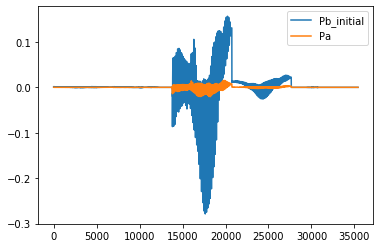

In [195]:
plt.plot(Pb_initial[0,:], label='Pb_initial')
plt.plot(Pa[0,:], label = 'Pa')
plt.legend()

In [198]:
np.var(Xb_initial[0:50]), np.var(Xa[0:50])

(0.29528862076607504, 4.108058033496582)

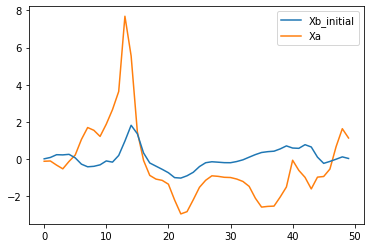

In [197]:
plt.plot(Xb_initial[0:50], label='Xb_initial',zorder=1)
plt.plot(Xa[0:50], label = 'Xa',zorder=0)
plt.legend()

In [209]:
limvars = ['tas','psl','zg','tos','sit','sic']

Ptrunc_initial = {}
standard_factor = {}
    
for var in limvars: 
#     [Ptrunc_initial[var], 
#     standard_factor[var]] = oda.project_validation_var(Xa[LIMd['var_dict'][var]['var_inds']][:,np.newaxis], 
#                                                        LIMd['E3'][var],LIMd['standard_factor'][var],
#                                                        LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])
    
    Ptrunc_initial[var] = oda.project_validation_var_og(Xa[LIMd['var_dict'][var]['var_inds']][:,np.newaxis], 
                                                        LIMd['E3'][var],LIMd['standard_factor'][var],
                                                        LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])

[ndof_all_initial, neof_all_initial] = oda.count_ndof_all(limvars, LIMd['E3'], sic_separate=False)

# [Ptrunc_all_initial, E3_all_initial] = oda.stack_variable_eofs_og(limvars, ndof_all_initial, 
#                                                                   LIMd['exp_setup']['ntrunc'],
#                                                                   Ptrunc_initial,LIMd['E3'],LIMd['var_dict'],
#                                                                   verbose=False)

# [Ptrunc_all_initial, E3_all_initial] = oda.stack_variable_eofs(limvars, ndof_all_initial, 
#                                                                LIMd['exp_setup']['ntrunc'],
#                                                                Ptrunc_initial,LIMd['E3'],LIMd['var_dict'],
#                                                                verbose=False)

[Ptrunc_all_initial, E3_all_initial,
 E3_all_stand_to,E3_all_stand_from] = oda.stack_variable_eofs_standardized2(limvars, ndof_all_initial, 
                                                                           LIMd['exp_setup']['ntrunc'],
                                                                           Ptrunc_initial,LIMd['E3'],
                                                                           LIMd['standard_factor'],
                                                                           LIMd['var_dict'],
                                                                           verbose=False)
# [Ptrunc_all_initial, E3_all_initial,
#  E3_all_stand_to,E3_all_stand_from] = oda.stack_variable_eofs_standardized(limvars, ndof_all_initial, 
#                                                                            LIMd['exp_setup']['ntrunc'],
#                                                                            Ptrunc_initial,LIMd['E3'],
#                                                                            standard_factor,LIMd['var_dict'],
#                                                                            verbose=False)

#     X_intial = np.concatenate((Ptrunc_all_initial, Ptrunc_sic_intial),axis=0)
X_initial = Ptrunc_all_initial

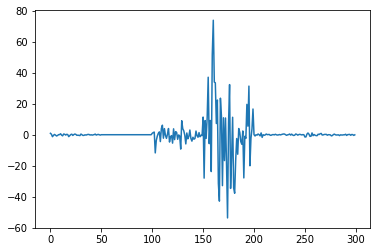

In [210]:
plt.plot(X_initial)

In [211]:
# P_left = np.matmul(E3_all_stand_to.T,Pa)
# Pa_projected = np.matmul(P_left,E3_all_stand_to)

P_left = np.matmul(E3_all_stand_to.T,Pa)
Pa_projected = np.matmul(P_left,E3_all_stand_to)

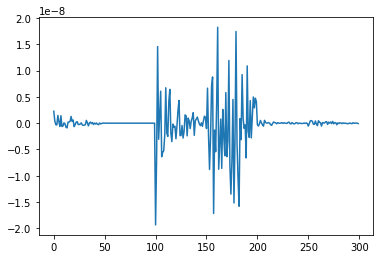

In [212]:
plt.plot(Pa_projected[0,:])

In [213]:
Pa_undo_right = np.matmul(E3_all_stand_from,Pa_projected) 
Pa_undo_right.shape

(35424, 300)

In [225]:
Pa_undo = np.matmul(Pa_undo_right, E3_all_stand_from.T) 

In [115]:
standard_matrix = np.ones((300))

standard_matrix[0:50] = standard_matrix[0:50]*standard_factor['tas']
standard_matrix[50:100] = standard_matrix[50:100]*standard_factor['psl']
standard_matrix[100:150] = standard_matrix[100:150]*standard_factor['zg']
standard_matrix[150:200] = standard_matrix[150:200]*standard_factor['tos']
standard_matrix[200:250] = standard_matrix[200:250]*standard_factor['sit']
standard_matrix[250:300] = standard_matrix[250:300]*standard_factor['sic']

In [116]:
E3_all_initial.shape, E3_stand.shape

((35424, 300), (35424, 300))

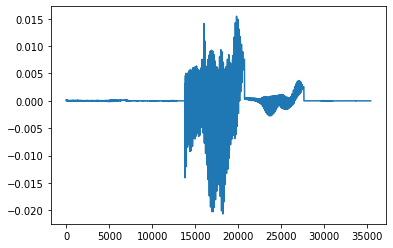

In [132]:
plt.plot(Pa[0,:])

In [120]:
E3_stand = E3_all_initial/standard_matrix[np.newaxis,:]

P_left = np.matmul(E3_stand.T,Pa)


(300, 35424)

In [121]:
Pa_projected = np.matmul(P_left,E3_stand)

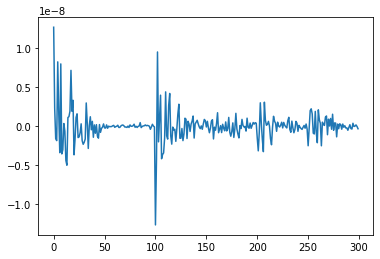

In [122]:
plt.plot(Pa_projected[0,:])

In [126]:
E3_stand.T.shape, Pa_projected.shape, P_left.shape

((300, 35424), (300, 300), (35424, 300))

In [125]:
E3_stand = E3_all_initial*standard_matrix[np.newaxis,:]

P_left = np.matmul(E3_stand,Pa_projected)

In [127]:
Pa_undo = np.matmul(Pa_projected,E3_stand.T)

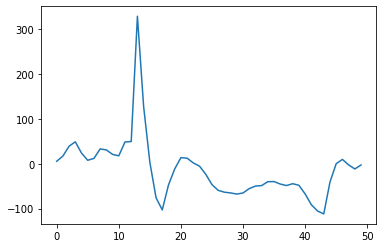

In [131]:
plt.plot(Pa_undo[0,0:50])

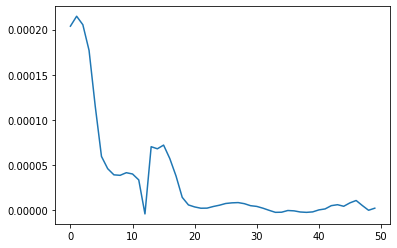

In [130]:
plt.plot(Pa[0,0:50])

In [ ]:
x = X_initial
lag = 1
adjust = True

In [ ]:
ndof = x.shape[0]
ntims = x.shape[1]
LIMfd = {}

max_eigenval = np.real(LIMd['lam_L']).max()

if adjust: 
    print('Adjust is True...')
    if max_eigenval >0: 
        print('YES negative eigenvalue found...adjusting')
        LIMd['frac_neg_eigenvals'] = ((LIMd['lam_L']>0).sum())/(LIMd['lam_L'].shape[0])
        LIMd['lam_L_adj'] = LIMd['lam_L'] - (max_eigenval+0.01)
    else: 
        print('NO negative eigenvalue found...')
        LIMd['frac_neg_eigenvals'] = 0
        LIMd['lam_L_adj'] = LIMd['lam_L']
else: 
    print('Adjust is False...')
    LIMd['frac_neg_eigenvals'] = np.nan
    LIMd['lam_L_adj'] = LIMd['lam_L']

print('lag=',lag)
# make the propagator for this lead time
Gt = np.real(np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam_L_adj']*lag))),LIMd['veci']))

# forecast mean state X:
if lag == 0:
    # need to handle this time separately, or the matrix dimension is off
    x_predict = np.matmul(Gt,x)
#           x_predict_save[k,:,:] = x_predict
else:
    x_predict = np.matmul(Gt,x)
#            x_predict_save[k,:,t:] = x_predict

# forecast covariance P:
product = np.matmul(np.matmul(Gt,LIMd['C_0']),Gt.T)
N = LIMd['C_0'] - product

x_cov = oda.covariance_nans(x,x.T,anomalize=False)
cov_product = np.matmul(np.matmul(Gt,x_cov),Gt.T)
Cov_predict = cov_product + N

In [ ]:
Weights = LIMd['exp_setup']['Weight']
W = LIMd['W_all'][var]

if Weights is True: 
    if len(W.shape)<2:
        W_new = W[:,np.newaxis]
    else: 
        W_new = W
    eofs_out = E3
    # projection
    P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X))

In [55]:
E3_all_initial.shape

(35424, 300)

In [57]:
Xb_initial_stand = np.zeros_like((Xb_initial))
Xvar_mn = {}
Xvar_std = {}

for var in limvars: 
    X_var = Xb_initial[LIMd['var_dict'][var]['var_inds']]

    Xvar_mn[var] = np.nanmean(X_var)
    Xvar_std[var] = np.std(X_var)

    Xvar_stand = (X_var - Xvar_mn[var])/Xvar_std[var]
    
    Xb_initial_stand[LIMd['var_dict'][var]['var_inds']] = Xvar_stand

(300, 35424)

In [ ]:
Xa[0:6912].min(), Xa[0:6912].max()

In [ ]:
Xb_initial[0:6912].min(), Xb_initial[0:6912].max()

In [ ]:
def project_validation_var(X, E3, standard_factor, W, Weights=False): 
    """
    """
    if Weights is True: 
        if len(W.shape)<2:
            W_new = W[:,np.newaxis]
        else: 
            W_new = W
        eofs_out = E3
        # projection
        P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X))
    else: 
        eofs_out = E3
        # projection
        P_var = np.matmul(eofs_out.T,np.nan_to_num(X))

    standard_factor = np.sqrt(np.var(P_var))
    Ptrunc = P_var/standard_factor
        
    return Ptrunc, standard_factor

In [ ]:
limvars = ['tas','psl','zg','tos','sit','sic']

In [ ]:
Ptrunc_initial = {}
standard_factor = {}
    
for var in limvars: 
    [Ptrunc_initial[var], 
    standard_factor[var]] = oda.project_validation_var(Xa[LIMd['var_dict'][var]['var_inds']][:,np.newaxis], 
                                                       LIMd['E3'][var],LIMd['standard_factor'][var],
                                                       LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])

[ndof_all_initial, neof_all_initial] = oda.count_ndof_all(limvars, LIMd['E3'], sic_separate=False)

[Ptrunc_all_initial, E3_all_initial] = oda.stack_variable_eofs(limvars, ndof_all_initial, 
                                                               LIMd['exp_setup']['ntrunc'],
                                                               Ptrunc_initial,LIMd['E3'],LIMd['var_dict'],
                                                               verbose=False)

#     X_intial = np.concatenate((Ptrunc_all_initial, Ptrunc_sic_intial),axis=0)
X_initial = Ptrunc_all_initial

In [ ]:
plt.plot(X_initial)
plt.ylim(-5,5)

In [ ]:
limvars

In [ ]:
plt.plot(Pa[0,:])

In [ ]:
plt.plot(Pb_initial[:,0])
plt.plot(Pa[:,0])

In [ ]:
standard_matrix = np.ones((300))

standard_matrix[0:50] = standard_matrix[0:50]*standard_factor['tas']
standard_matrix[50:100] = standard_matrix[0:50]*standard_factor['psl']
standard_matrix[100:150] = standard_matrix[0:50]*standard_factor['zg']
standard_matrix[150:200] = standard_matrix[0:50]*standard_factor['tos']
standard_matrix[200:250] = standard_matrix[0:50]*standard_factor['sit']
standard_matrix[250:300] = standard_matrix[0:50]*standard_factor['sic']

In [ ]:
var = 'tas'
Pa_proj = project_validation_var(Pa[LIMd['var_dict'][var]['var_inds']], 
                                 LIMd['E3'][var],LIMd['standard_factor'][var],
                                 LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])

In [ ]:
(E3_all_initial.T/standard_matrix[:,np.newaxis]).shape

In [ ]:
Pa_left2 = np.matmul((E3_all_initial.T),Pb_allvars)

In [ ]:
np.var(Pa_left2[0,6912:(6912*2)])

In [ ]:
Pa_proj = np.matmul(Pa_left2, E3_all_initial)

In [ ]:
plt.plot(Pa_proj[:,0])

In [ ]:
plt.plot(Pa_left2[:,0])

In [ ]:
plt.plot(Pa_left[:,0])

In [ ]:
Pb_test = Pb_initial[0,:]/(stand_fact)

In [ ]:
np.var(Pb_test[0:6912])

In [ ]:
plt.plot(Pb_initial[0,:]/(stand_fact))

In [ ]:
Pb_initial[0,:].shape

In [ ]:
plt.plot(Xb_initial[])

In [ ]:
stand = {}
for var in limvars: 
    stand[var] = np.sqrt(np.var(Xb_initial[LIMd['var_dict'][var]['var_inds']]))

In [ ]:
stand

In [ ]:
stand_fact = np.ones_like(Xb_initial)
for var in limvars: 
    stand_fact[LIMd['var_dict'][var]['var_inds']] = stand_fact[LIMd['var_dict'][var]['var_inds']]*stand[var]

In [ ]:
Pb_allvars = oda.covariance_nans((Xb_initial/stand_fact)[:,np.newaxis],
                                 (Xb_initial/stand_fact)[:,np.newaxis].T, anomalize=False)

In [ ]:
np.var(Pb_allvars[0,0:6912])

In [ ]:
 plt.plot(Pb_allvars[0,:])

In [ ]:
 plt.plot(Pb_allvars[:,0])

In [ ]:
np.var(Pb_allvars[0:6912,0])

In [ ]:
plt.plot(Ptrunc_initial['tos'])
plt.plot(Ptrunc_initial['zg'])
plt.plot(Ptrunc_initial['tas'])

plt.ylim(-1,1)

In [ ]:
Pa_calc = oda.covariance_nans(X_initial, X_initial.T,anomalize=False)

In [ ]:
Pa_trunc = np.matmul(np.matmul(E3_all_initial.T,Pa),E3_all_initial)

In [ ]:
plt.plot(Pa_trunc[0,:])

In [ ]:
P_weighted = np.zeros_like(Pa)

for var in limvars:
    print('Working on '+var)
    standard_factor = LIMd['standard_factor'][var]
    E3 = LIMd['E3'][var]
    W = LIMd['W_all'][var]
    Weights = LIMd['exp_setup']['Weight']
    var_inds = LIMd['var_dict'][var]['var_inds']
    X = Pa[var_inds[0]:var_inds[-1]+1,var_inds[0]:var_inds[-1]+1]

    if Weights is True: 
        if len(W.shape)<2:
            W_new = W[:,np.newaxis]
        else: 
            W_new = W
        factor = (W_new/standard_factor)**2
        
        P_weighted[var_inds[0]:var_inds[-1]+1,var_inds[0]:var_inds[-1]+1] = (factor*np.nan_to_num(X))

In [ ]:
Pa_trunc = np.matmul(np.matmul(E3_all_initial.T,P_weighted),E3_all_initial)

In [ ]:
Pa_trunc.shape

In [ ]:
plt.pcolormesh(Pa_trunc)

In [ ]:
plt.pcolormesh(Pa_trunc)

In [ ]:
plt.pcolormesh(Pa_calc)

In [ ]:
LIM_Xfcast = oda.LIM_forecast(LIMd,X_initial,1,adjust=False)

In [ ]:
LIM_Xfcast['x_forecast']

In [ ]:
Xb_intitial, E3_all = oda.decompress_eof_separate_sic(LIM_Xfcast['x_forecast'],LIMd)

In [ ]:
x = X_initial
lag = 1
adjust = True

In [ ]:
ndof = x.shape[0]
ntims = x.shape[1]
LIMfd = {}

max_eigenval = np.real(LIMd['lam_L']).max()

if adjust: 
    print('Adjust is True...')
    if max_eigenval >0: 
        print('YES negative eigenvalue found...adjusting')
        LIMd['frac_neg_eigenvals'] = ((LIMd['lam_L']>0).sum())/(LIMd['lam_L'].shape[0])
        LIMd['lam_L_adj'] = LIMd['lam_L'] - (max_eigenval+0.01)
    else: 
        print('NO negative eigenvalue found...')
        LIMd['frac_neg_eigenvals'] = 0
        LIMd['lam_L_adj'] = LIMd['lam_L']
else: 
    print('Adjust is False...')
    LIMd['frac_neg_eigenvals'] = np.nan
    LIMd['lam_L_adj'] = LIMd['lam_L']

print('lag=',lag)
# make the propagator for this lead time
Gt = np.real(np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam_L_adj']*lag))),LIMd['veci']))

# forecast mean state X:
if lag == 0:
    # need to handle this time separately, or the matrix dimension is off
    x_predict = np.matmul(Gt,x)
#           x_predict_save[k,:,:] = x_predict
else:
    x_predict = np.matmul(Gt,x)
#            x_predict_save[k,:,t:] = x_predict

# forecast covariance P:
product = np.matmul(np.matmul(Gt,LIMd['C_0']),Gt.T)
N = LIMd['C_0'] - product

x_cov = oda.covariance_nans(x,x.T,anomalize=False)
cov_product = np.matmul(np.matmul(Gt,x_cov),Gt.T)
Cov_predict = cov_product + N

In [ ]:
Cov_predict.min(), Cov_predict.max()

In [ ]:
x_predict.min(), x_predict.max(), x.min(),x.max()

In [ ]:
nmodes = LIMd['E3_all'].shape[1]

Xb_intitial, E3_all = oda.decompress_eof_separate_sic(x_predict,LIMd)

Pb_initial = np.matmul(np.matmul(E3_all,Cov_predict),E3_all.T)

In [ ]:
Pb_initial.min(), Pb_initial.max()

In [ ]:
Xb_intitial.min(), Xb_intitial.max()

In [ ]:
np.nanmin(Xb_allvars_initial), np.nanmax(Xb_allvars_initial)

In [ ]:
(Pb_data['Pb_initial']/10).min(), (Pb_data['Pb_initial']/10).max()

In [ ]:
np.concatenate((LIMd['E3_all'], LIMd['E_sic']), axis=0).shape

In [ ]:
X_initial.min(), X_initial.max()

In [ ]:
plt.plot(X_initial)
plt.ylim(0,10)

In [ ]:
limvars

In [ ]:
plt.plot(Xb_allvars_initial)
plt.ylim(0,10)

In [ ]:
np.nanvar(Xb_allvars_initial[0:9612])

In [ ]:
Pa = oda.solver_KF_cov(K,H,Pb_initial)

In [ ]:
mse_xb = np.nanmean(diff**2)
mse_xa = np.nanmean((Y - np.matmul(H,Xa))**2)

In [ ]:
print('Prior MSE     = '+str(mse_xb))
print('Posterior MSE = '+str(mse_xa))

In [ ]:
cesmdir = '/home/disk/chaos/mkb22/Documents/SeaIceData/LME/LIMs/'
filename = 'tas_sfc_Amon_CESM_LMEallforc_001_085001-200512.nc'
data_cesm_lme = xr.open_dataset(cesmdir+filename)
cesm_lat = data_cesm_lme.lat.values
cesm_lat_nh = cesm_lat[48:]
cesm_lon = data_cesm_lme.lon.values

In [ ]:
ref_arg_lon = [int(i) for i in locations[0]['reference_arg_lon']]
ref_arg_lat = [int(i) for i in locations[0]['reference_arg_lat']]

In [ ]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

axs.pcolormesh(cesm_lon,cesm_lat_nh,np.reshape(Xb_initial[0:6912],(48,144)),
               cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-18, vmax=18)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
                s=40,c=HadCRUT_obs_1d,cmap='RdBu_r',edgecolor='k',
                 transform=ccrs.PlateCarree(),vmin=-18, vmax=18)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Prior vs. HadCRUT Observations', fontsize=18)

In [ ]:
fig = plt.figure(1, figsize=(16, 6))
axs = plt.axes(projection=ccrs.Robinson())
axs.coastlines()

axs.pcolormesh(cesm_lon,cesm_lat_nh,np.reshape(Xa[0:6912],(48,144)),
               cmap='RdBu_r',transform=ccrs.PlateCarree(),vmin=-18, vmax=18)

cb = axs.scatter(cesm_lon[ref_arg_lon],cesm_lat_nh[ref_arg_lat],
                s=40,c=HadCRUT_obs_1d,cmap='RdBu_r',edgecolor='k',
                 transform=ccrs.PlateCarree(),vmin=-18, vmax=18)

plt.colorbar(cb, orientation='horizontal', shrink=0.7, label='K')
plt.title('Analysis vs Observations', fontsize=18)

## Initial timestep - Forecast: 
1. First project analysis (covariance and mean state) into EOF space:  
2. Forecast (covariance and mean state) one timestep
3. Project back into full field space for assimilation at time t = t + dt

In [ ]:
def project_validation_var(X, E3, standard_factor, W, Weights=False): 
    """
    """
    if Weights is True: 
        if len(W.shape)<2:
            W_new = W[:,np.newaxis]
        else: 
            W_new = W
        eofs_out = E3/standard_factor
        # projection
        P_var = np.matmul(eofs_out.T,W_new*np.nan_to_num(X))
    else: 
        eofs_out = E3/standard_factor
        # projection
        P_var = np.matmul(eofs_out.T,np.nan_to_num(X))

    Ptrunc = P_var/standard_factor
        
    return Ptrunc

In [ ]:
def stack_variable_eofs(limvars, ndof_all, ntrunc, Ptrunc, E3, 
                        var_dict,nmonths=1,sic_separate=False, 
                        verbose=False): 
    start = 0
    if sic_separate is True: 
        limvars_nosic = [l for l in limvars if l not in 'sic']
        nvars = len(limvars_nosic)
        E3_all = np.zeros([ndof_all,int(ntrunc*(nvars)),nmonths])
        if nmonths == 1: 
            E3_all = np.squeeze(E3_all)

        for v,var in enumerate(limvars_nosic):
            print(str(v) + ', '+var)
            if v == 0: 
                Ptrunc_all = Ptrunc[var]
            else: 
                Ptrunc_all = np.concatenate((Ptrunc_all,Ptrunc[var]),axis=0)
                
            E3_all[var_dict[var]['var_inds'],int(v*ntrunc):int((v+1)*ntrunc)] = E3[var]
            
            if verbose is True: 
                print(E3_all[18430:18435,0])
                print('start: '+str(start)+' end: '+str(start+var_dict[var]['var_ndof'])+' '+str(v*ntrunc))
#            start = start+var_dict[var]['var_ndof']

        Ptrunc_sic = Ptrunc['sic']
        E_sic = E3['sic']
    else: 
        nvars = len(limvars)
        E3_all = np.zeros([ndof_all,int(ntrunc*(nvars))])
        if nmonths == 1: 
            E3_all = np.squeeze(E3_all)

        for v,var in enumerate(limvars):
            if v == 0: 
                Ptrunc_all = Ptrunc[var]
            else: 
                Ptrunc_all = np.concatenate((Ptrunc_all,Ptrunc[var]),axis=0)
            E3_all[var_dict[var]['var_inds'],int(v*ntrunc):int((v+1)*ntrunc)] = E3[var]
            
            if verbose is True:
                print(E3_all[18430:18435,0])
                print('start: '+str(start)+' end: '+str(start+var_dict[var]['var_ndof'])+' '+str(v*ntrunc))
#            start = start+var_dict[var]['var_ndof']
            
    if sic_separate == True: 
        return Ptrunc_all, E3_all, Ptrunc_sic, E_sic
    else: 
        return Ptrunc_all, E3_all

In [ ]:
def count_ndof_all(limvars, E3, sic_separate=False): 
    #Count total degrees of freedom: 
    if sic_separate is True: 
        if len(limvars) <2: 
            ndof_all = 0
        else: 
            limvars_nosic = [l for l in limvars if l not in 'sic']
            for v,var in enumerate(limvars_nosic):
                if v == 0: 
                    ndof_all = E3[var].shape[0]
                else: 
                    ndof_all = ndof_all+E3[var].shape[0]
    else: 
        for v,var in enumerate(limvars):
            if v == 0: 
                ndof_all = E3[var].shape[0]
            else: 
                ndof_all = ndof_all+E3[var].shape[0]
            print(ndof_all)
            
    return ndof_all


In [ ]:
def get_var_indices(limvars, var_dict): 
    """Get indices for each variable
    """
    start = 0
    for k, var in enumerate(limvars): 
        print('working on '+var)
        inds = var_dict[var]['var_ndof']
        var_inds = np.arange(start,start+inds,1)
        start = inds+start

        var_dict[var]['var_inds'] = var_inds
        
    return var_dict

In [ ]:
def LIM_forecast(LIMd,x,lag,adjust=True):
    """
    # There is a bug with this forecast function function: It uses the eigenvectors and 
    #        values to calculate Gt, but it's giving the same value for all lags in the forecast
    
    deterministic forecasting experiments for states in x and time lags in lags.

    Inputs:
    * LIMd: a dictionary with LIM attributes
    * x: a state-time matrix for initial conditions and verification ~(ndof,ntims)
    * lags: list of time lags for deterministic forecasts
    * adj: True/False, if True removes negative eigenvalues 
    
    Outputs (in a dictionary):
    *'error' - error variance as a function of space and forecast lead time (ndof,ntims)
    *'x_forecast' - the forecast states (nlags,ndof,ntims)
    *'x_truth_phys_space' - true state in physical space (nlat*nlon,*ntims)
    *'x_forecast_phys_space' - forecast state in physical space (nlat*nlon,*ntims)
    """
    
    ndof = x.shape[0]
    ntims = x.shape[1]
    nlags = len(lags)
    LIMfd = {}
    
    max_eigenval = np.real(LIMd['lam_L']).max()
    
    if adjust: 
        print('Adjust is True...')
        if max_eigenval >0: 
            print('YES negative eigenvalue found...adjusting')
            LIMd['frac_neg_eigenvals'] = ((LIMd['lam_L']>0).sum())/(LIMd['lam_L'].shape[0])
            LIMd['lam_L_adj'] = LIMd['lam_L'] - (max_eigenval+0.01)
        else: 
            print('NO negative eigenvalue found...')
            LIMd['frac_neg_eigenvals'] = 0
            LIMd['lam_L_adj'] = LIMd['lam_L']
    else: 
        print('Adjust is False...')
        LIMd['frac_neg_eigenvals'] = np.nan
        LIMd['lam_L_adj'] = LIMd['lam_L']
    
    print('lag=',lag)
    # make the propagator for this lead time
    Gt = np.matmul(np.matmul(LIMd['vec'],np.diag(np.exp(LIMd['lam_L_adj']*t))),LIMd['veci'])

    # forecast mean state X:
    if lag == 0:
        # need to handle this time separately, or the matrix dimension is off
        x_predict = np.matmul(Gt,x)
#           x_predict_save[k,:,:] = x_predict
    else:
        x_predict = np.matmul(Gt,x[:,:-t])
#            x_predict_save[k,:,t:] = x_predict
    
    # forecast covariance P:
    product = np.matmul(np.matmul(Gt,LIMd['C_0']),Gt.T)
    Cov_predict = LIMd['C_0'] - product

    Ld = {}
    Ld['Gt'] = Gt
    LIMfd[lag] = Ld

    LIMfd['x_forecast'] = np.squeeze(x_predict)  
    LIMfd['Cov_forecast'] = Cov_predict
        
    return LIMfd

In [ ]:
def unweight_decompressed_vars(x_train_dcomp, limvars, var_dict, W_all):
    """
    INPUTS: 
    ========
    x_train_dcomp
    limvars
    var_dict
    W_all
    
    OUTPUTS: 
    ========
    X_out 
    """
    X_out = np.zeros_like(x_train_dcomp)
    
    start=0
    if len(x_train_dcomp.shape)<2:
        for var in (limvars):
            inds_end = var_dict[var]['var_ndof']
            X_out[start:start+inds_end] = x_train_dcomp[start:start+inds_end]/W_all[var][:]
            start = start+inds_end
    else:
        for var in (limvars):
            inds_end = var_dict[var]['var_ndof']
            X_out[start:start+inds_end,:] = x_train_dcomp[start:start+inds_end,:]/W_all[var][:,np.newaxis]
            start = start+inds_end
        
    return X_out

In [ ]:
def decompress_eof_separate_sic(X_proj, LIMd):
    """
    INPUTS: 
    ========
    P_train
    nmodes
    nmodes_sic
    E
    E_sic
    limvars
    var_dict
    W_all
    Weights=True
    sic_separate=False
    
    OUTPUTS: 
    ========
    X_train_dcomp
    """
    E3_all = np.zeros((LIMd['E3_all'].shape[0]+LIMd['E_sic'].shape[0], 
                   LIMd['E3_all'].shape[1]+LIMd['E_sic'].shape[1]))

    E3_all[0:LIMd['E3_all'].shape[0],0:LIMd['E3_all'].shape[1]] = LIMd['E3_all']
    E3_all[LIMd['E3_all'].shape[0]:,LIMd['E3_all'].shape[1]:] = LIMd['E_sic']

    X_dcomp = np.matmul(E3_all,X_proj)

    if LIMd['exp_setup']['Weight'] is True: 
        X_train_dcomp = unweight_decompressed_vars(X_dcomp, LIMd['exp_setup']['limvars'], 
                                                   LIMd['var_dict'], LIMd['W_all'])
    else: 
        X_train_dcomp = x_train_dcomp
    
    return X_train_dcomp

In [ ]:
LIMd['W_all'].keys()

### Project analysis into LIM space: 

In [ ]:
# for var in limvars: 
#     Ptrunc_initial[var] = project_validation_var(Xa[LIMd['var_dict'][var]['var_inds']], LIMd['E3'][var],
#                                                  LIMd['standard_factor'][var],
#                                                  LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])

# ndof_all_intial = count_ndof_all(limvars, LIM['E3'], sic_separate=LIMd['exp_setup']['sic_separate'])

# [Ptrunc_all_initial, E3_all_initial,
#  Ptrunc_sic_initial, E_sic_initial] = limkb.stack_variable_eofs(LIMd['exp_setup']['limvars'], ndof_all_initial, 
#                                                                 LIMd['exp_setup']['ntrunc'],Ptrunc_intial, 
#                                                                 LIMd['E3'], LIMd['var_dict'])

# X_intial = np.concatenate((Ptrunc_all_initial, Ptrunc_sic_intial),axis=0)

In [ ]:
limvars = ['tas','psl','zg','tos','sit','sic']

In [ ]:
Ptrunc_initial = {}

for var in limvars: 
    Ptrunc_initial[var] = oda.project_validation_var(Xa[LIMd['var_dict'][var]['var_inds']][:,np.newaxis], 
                                                     LIMd['E3'][var],LIMd['standard_factor'][var],
                                                     LIMd['W_all'][var], Weights=LIMd['exp_setup']['Weight'])

[ndof_all_initial, neof_all_initial] = oda.count_ndof_all(limvars, LIMd['E3'], sic_separate=False)

In [ ]:
Ptrunc_initial[var].shape

In [ ]:
[Ptrunc_all_initial, _] = oda.stack_variable_eofs(limvars, ndof_all_initial, 
                                                  LIMd['exp_setup']['ntrunc'],Ptrunc_initial, 
                                                  LIMd['E3'], LIMd['var_dict'],verbose=False)

#     X_intial = np.concatenate((Ptrunc_all_initial, Ptrunc_sic_intial),axis=0)
X_initial = Ptrunc_all_initial

In [ ]:
nvars = len(limvars)
E3_all = np.zeros([ndof_all_initial,int(LIMd['exp_setup']['ntrunc']*(nvars))])

In [ ]:
X_initial.shape

### Forecast: 

In [ ]:
print('Performing forecast...')
LIM_Xfcast = oda.LIM_forecast(LIMd,X_initial,1,adjust=LIMd['exp_setup']['adj'])

### Project back into full field space: 

In [ ]:
nmodes = LIMd['E3_all'].shape[1]

In [ ]:
Xb_intitial, E3_all = oda.decompress_eof_separate_sic(LIM_Xfcast['x_forecast'],LIMd)

In [ ]:
Pb_initial = np.matmul(np.matmul(E3_all,LIM_Xfcast['cov_forecast']),E3_all.T)

In [ ]:
E3_all.shape, LIM_Xfcast.keys()

In [ ]:
import datetime

t_total = 13
years = int(1850+np.floor((t_total-1)/12))
time = np.array([datetime.datetime(y, m, 15) for y in np.arange(1850,years,1) for m in np.arange(1,13,1)])

In [ ]:
years

In [ ]:
Xb_initial.shape[0]

In [ ]:
Pb_initial = np.matmul(np.matmul(E3_all,LIM_Xfcast['cov_forecast']),E3_all.T)